In [1]:
import pandas as pd
import os
import urllib
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np
from scipy.signal import periodogram
import statsmodels.api as sm
import dask.dataframe as dd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import warnings
warnings.filterwarnings('ignore')

# Theoretic part (20 pts, 5 pts each)

Multiple choice questions: please select all that applies and explain your answer.

### Question 1 (Autocorrelation). 
The autocorrelation plot of the daily time-series has local peaks at t=7,14,21,28 etc.. How would you interpret that?

A. The time-series reaches its maximum on the days 7,14,21,28...

B. The time-series reaches its minimum on the days 7,14,21,28...

C. The time-series is likely to have a periodic pattern with a period of 7 days

D. The time-series is likely to have 7 periods per day

E. The appropriate AR model for the time-series should have at least 7 terms.

Answer: C. Repeated local peaks of the autocorrelation often highlight the periodic pattern in the data, while the likely length of the period is the gap between those local peaks.

### Question 2 (Stationarity).

Which of the following time-series models are stationary:

A. Linear trend

B. AR(1) model

C. White noise

D. Random walk

E. ARMA(1,2) model

F. ARIMA(1,1,1) model

Answer: B,C,D,E. White noise as well as AR, MA, ARMA models are known to be stationary. Any model with a trend is not as the trend assumes changing mean of the time-series changing over time. A random walk is not stationary as its variance accumulates over time. ARIMA with at least one differencing, including ARIMA(1,1,1) is not stationary.

### Question 3 (PCA). 
Which of the following statements regarding the model dimensionality reduction through Principal Component Analysis (PCA) are true:

A. Leading principal components of the features are the most efficient for modeling the output variable.

B. Principal components of the standardized features are uncorrelated and this way less exposed to multicollinearity.

C. The model using principal components of the features can't overfit.

D. Feature selection based on the principal components of the features is often more efficient in preventing overfitting comparered the feature selection over the original features.

E. Principal components are harder to interpret compared to the original features making the PCA regresssion model less interpretable compared to the regression model using original features.

Answer: B, D, E. The principal components of the standardized features are uncorrelated. This also helps feature selection as the impacts of different principal components on the output variable are independent and do not overlap. Also the principal components may represent uneven volumes of relevant information, this way increasing the odds of finding a smaller number of features representing enough relevant information. Also despite their advantages, Principal components are harder to interpret compared to the original features making the PCA regresssion model less interpretable compared to the regression model using original features.

### Question 4 (MapReduce). 

What is true about MapReduce:

A. MapReduce is a Python module enabling parallel computing

B. Using MapReduce approach makes the code more suitable for parallel computing.

C. MapReduce code always runs faster compared to the code using more traditional approaches, like loops or list comprehensions.

D. MapReduce code will always efficiently run on multiple cores of you CPU or multiple machines within your cluster if available.

E. Multiprocessing and PySpark efficient alternatives to MapReduce.



Answer: B. MapReduce is a programming paradigm but not a specific Python module. MapReduce code is suitable for parallel computing as different map operations and groups of reduce operations over different chucks of data could be run independently. However, MapReduce code is not guaranteed to have higher performance unless using efficient parallel computing technology, like multiprocessing or PySpark (even better). Without using those map and reduce operations of the MapReduce code won't be parallelized by default. With that multiprocessing and PySpark are not altenatives to MapReduce, but rather technological solutions for parallelizing MapReduce code (although they are not limited to that).

# Practice part: Taxi ridership from JFK to other taxi zones prediction.
This project is an example of applying PCA to predict hourly yellow taxi ridership at the taxi zone level. Modeling taxi ridership at a fine spatial and temporal granularity is challenging due to the low signal-to-noise ratio and high dimensionality. In this case, dimension reduction essential in feature engineering. This project has five steps: data downloading, data preprocessing, baseline modeling, feature engineering, and RandomForest modeling.

Let's start with data downloading. 

## 1. Data downloading (5pts)
Design a function to download yellow taxi data from 2017-01-01 to 2018-12-31 at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.

In [11]:
dataDir = '/Users/devashishkhulbe/Desktop/teaching/ADS_2021_labs/Solutions-main/midterm_data/'
Years = [2017,2018]
Months = range(1,13)
VehicleTypes = ['yellow']

def getUrl(cabtype,year,month):
    baseUrl = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
    
    month = str(month).zfill(2)
    fileName = '%s_tripdata_%s-%s.csv'%(cabtype,year,month)
        
    return baseUrl + fileName, fileName        

In [ ]:
for year in Years:
    for month in Months:
        for cabtype in VehicleTypes:
            url, fileName = getUrl(cabtype,year,month)
            
            print("Downloading: "+str(fileName))
            
            if fileName in os.listdir(dataDir):
                print("file exists")
                continue
            
            filePath = os.path.join(dataDir, fileName)
            try:
                urllib.request.urlretrieve(url, filePath)
            except:
                # if fails remove the incomplete file
                os.remove(filePath)
                try:
                    # start again after a delay of 2 min
                    time.sleep(60*2)
                    urllib.request.urlretrieve(url, filePath)
                except:
                    print("Download this file later!")
                    pass


## 2. Data Preprocessing (10 pts, 7 for dask, 3 for sanity check)
Use dask to aggregate all months' records into one dataframe, and aggregate dataset by date and hour to get the ridership from JFK to each taxi zone each hour. The expected output has columns: date, hour, drop-off location 1, drop-off location 2, etc. 

Hint: 
1. JFK taxi zone id is 132.
2. time column should be the pickup time, and ridership is passenger count.
3. Try read_csv("*.csv") to read all csv file in a folder 
4. files in 2017 and 2018 have different columns; apply argument usecols to select desired columns.
5. using .compute() function to convert processed dask dataframe to pandas dataframe for further modeling.

### 2.1 Data loading

In [3]:
df = dd.read_csv(dataDir+'*.csv',
                 dtype={'DOLocationID': 'float64',
                       'passenger_count': 'float64'},
                usecols=['PULocationID','DOLocationID','passenger_count','tpep_pickup_datetime'])
df = df.loc[df['PULocationID']==132]
df['date'] = df.apply(lambda x:x['tpep_pickup_datetime'].split(' ')[0],axis=1)
df['year'] = df.apply(lambda x:x['date'].split('-')[0],axis=1)
df = df.loc[df['year'].isin(['2017','2018'])]

def getHour(x):
    time = x['tpep_pickup_datetime']
    if len(time.split(' '))>1:
        hour = time.split(' ')[1].split(':')[0]
        return hour
    else:
        return np.nan

df['hour'] = df.apply(lambda x:getHour(x), axis=1)
df = df.groupby(['date','hour','DOLocationID']).agg({'passenger_count':'sum'})

In [70]:
JFKridership = df.compute()

In [71]:
JFKridership = JFKridership.sort_index()
JFKridership = JFKridership.reset_index()
JFKridership = pd.pivot_table(JFKridership, values='passenger_count', index=['date','hour'],
                    columns=['DOLocationID'], aggfunc=np.sum, fill_value=0)

In [72]:
JFKridership

DOLocationID     1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0    \
date       hour                                                           
2017-01-01 00        0      0      0      1      0      0      2      0   
           01        0      0      0      2      0      0      5      0   
           02        0      0      0      0      0      0      0      0   
           03        0      0      0      0      0      0      1      0   
           04        0      0      0      0      0      0      0      0   
...                ...    ...    ...    ...    ...    ...    ...    ...   
2018-12-31 19        0      0      0      0      0      0      4      0   
           20        1      0      0      0      0      0      7      0   
           21        0      0      0      2      0      0      9      0   
           22        0      0      2      2      0      0      2      0   
           23        5      0      0      7      0      0      6      0   

DOLocationID     9.0    10.0   ...  256.0  257.0  258.0  259.0  260.0  261.0  \
date       hour                ...                                             
2017-01-01 00        0      7  ...      0      3      0      0      1      0   
           01        0      8  ...      6      0      0      0      0      5   
           02        1      3  ...      0      0      2      0      0      0   
           03        0      0  ...      1      0      2      0      0      0   
           04        0      0  ...      0      0      0      0      0      0   
...                ...    ...  ...    ...    ...    ...    ...    ...    ...   
2018-12-31 19        1     14  ...      3      1      5      0      2      5   
           20        0     25  ...      6      4      0      0      8      1   
           21        0      3  ...      4      5      5      0      1      1   
           22        0      4  ...      1     11      0      1      0      5   
           23        0      7  ...      0     11      0      0      1      1   

DOLocationID     262.0  263.0  264.0  265.0  
date       hour                              
2017-01-01 00        3      0      3     27  
           01        7      6      1     12  
           02        0      0      0     10  
           03        0      0      0      4  
           04        0      0      0      3  
...                ...    ...    ...    ...  
2018-12-31 19       19     15      0     23  
           20        9     13      0     16  
           21       16     13      4     23  
           22       16      9      0     25  
           23        8     13      0     25  

[17518 rows x 263 columns]

### 2.2 Sanity check
Then, we need to do some basic sanity checks. It is possible that in a particular hour, completely dispatched no yellow taxis from JFK. Check does each day has 24-hour records and add missing records back to the dataframe. The final output should have 17520 rows ($365\times2\times24$)

In [73]:
sanityCheck = JFKridership.reset_index().groupby(['date']).agg({"hour":'count'})
sanityCheck.loc[sanityCheck['hour']<24]

,hour
date,
2017-03-12,23
2018-03-11,23


In [74]:
grid = pd.DataFrame({'date':['2017-03-12']*24+['2018-03-11']*24,'hour':list(range(0,24))+list(range(0,24))})
grid['hour'] = grid['hour'].apply(lambda x:str(x).zfill(2))
JFKridership = JFKridership.reset_index().merge(grid,how='outer').fillna(0).sort_values(by=['date','hour'])

## 3. Time-series exploratory analysis
Apply exploratory analysis over the daily aggregated dataset at first.

### 3.1 aggregate the ridership from each dropoff location and sum it to get daily records. (3pts)

In [82]:
JFKridershipDaily = pd.DataFrame(JFKridership.groupby(['date']).sum().sum(axis=1),columns=['passenger_count'])
JFKridershipDaily.index = pd.to_datetime(JFKridershipDaily.index)
JFKridershipDaily.head()

,passenger_count
date,
2017-01-01,14710.0
2017-01-02,16723.0
2017-01-03,16072.0
2017-01-04,14549.0
2017-01-05,12239.0


### 3.2 Period detection and report the strongest period length on the 2017 data. (3pts)
Hint: using periodogram or acf plot.

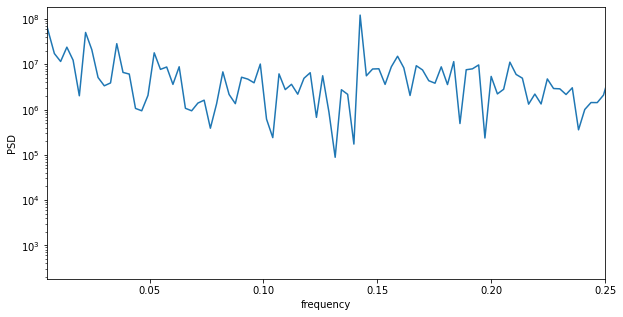

Strongest period length = 7.019230769230769


In [84]:
f, PSD = periodogram(JFKridershipDaily.passenger_count[:365])
plt.semilogy(f, PSD)
plt.xlabel('frequency')
plt.ylabel('PSD')
plt.xlim(0.005,0.25) 
plt.ylim(max(PSD)/1e6,max(PSD))

PSD = PSD[f>0.005]
f = f[f>0.005]
plt.show()
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)])) 

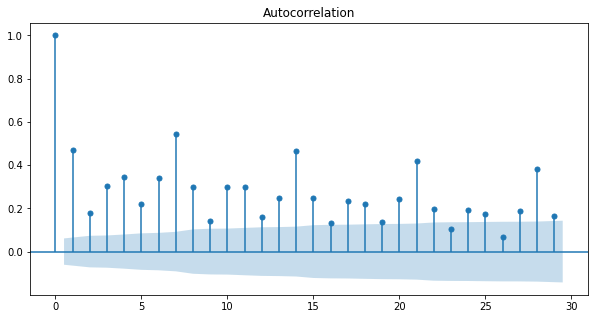

In [104]:
_ = plot_acf(JFKridershipDaily.passenger_count, alpha=0.1)

### 3.3 Trend, seasonality, noise decomposition (using additive model) on 2017 data, . (3 pts, 1 pts if freq is wrong)

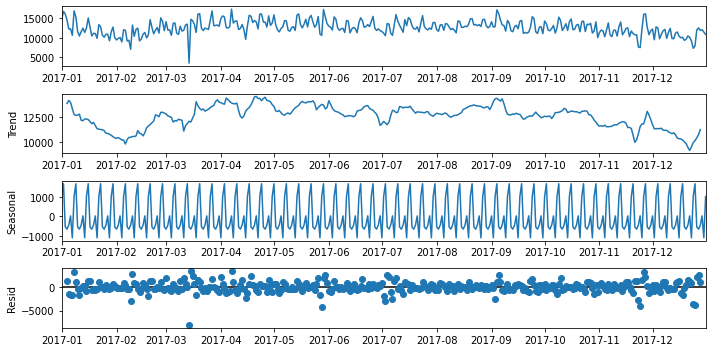

In [85]:
res = sm.tsa.seasonal_decompose(JFKridershipDaily[:365],model='additive',freq=7)
res.plot()
plt.show()

## 4. Predict the total daily ridership from JFK using ARIMA.
ARIMA is a common method to predict taxi ridership. Before we predict taxi zone level hourly ridership, let's try to predict the aggregated daily ridership using ARIMA.

### 4.1 Using adfuller test to test the stability of the aggregated dataset. If not stable, apply differencing method until the p-value from adfuller test is smaller than 0.05. (3pts)

In [60]:
result = adfuller(JFKridershipDaily.values)
print('p-value: %f' % result[1])

result = adfuller(JFKridershipDaily.diff().dropna().values)
print('p-value: %f' % result[1])

p-value: 0.223642
p-value: 0.000000


### 4.2 Find out proper AR and MA terms in an ARIMA model using pacf and acf plots. (4 pts, 2 for each plot)
Hint: positive autocorrelation is usually best treated by adding an AR term to the model and negative autocorrelation is usually best treated by adding an MA term. In general, differencing reduces positive autocorrelation and may even cause a switch from positive to negative autocorrelation. 

Identifying the numbers of AR and MA terms:
1. if the pacf plot shows a sharp cutoff and/or the lag-1 autocorrelation is positive then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

2. if the acf plot displays a sharp cutoff and/or the lag-1 autocorrelation is negative then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

3. It is generally advisable to stick to models in which at least one of p and q is no larger than 1, i.e., do not try to fit a model such as ARIMA(2,1,2).

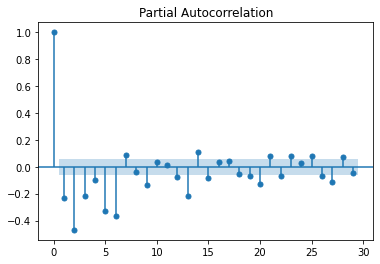

In [49]:
_ = plot_pacf(JFKridershipDaily.passenger_count.diff().dropna(), alpha=0.1)

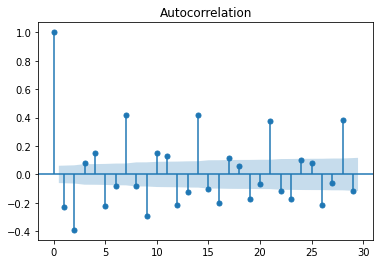

In [50]:
_ = plot_acf(JFKridershipDaily.passenger_count.diff().dropna(), alpha=0.1)

### 4.3 build an ARIMA model using terms from 4.2, training on the first 700 days, forecast on the last 31 days. Print ARIMA model results and plot in-sample and out-of-sample prediction in different colors. (8 pts, 3 for correct terms, 3 for training and summary, 2pts for the plot)

In [105]:
P=0
D=1
Q=1

# fit model
N = 700   
series = JFKridershipDaily.passenger_count
model = ARIMA(series[:N+1], order=(P,D,Q))
model_fit = model.fit(disp = 0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.passenger_count   No. Observations:                  700
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6148.804
Method:                       css-mle   S.D. of innovations           1578.121
Date:                Mon, 22 Mar 2021   AIC                          12303.607
Time:                        21:41:24   BIC                          12317.260
Sample:                    01-02-2017   HQIC                         12308.885
                         - 12-02-2018                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.7667      7.103     -0.530      0.596     -17.688      10.154
ma.L1.D.passenger_count    -0.8823      0.020    -45.220      0.000      -0.921      -0.844


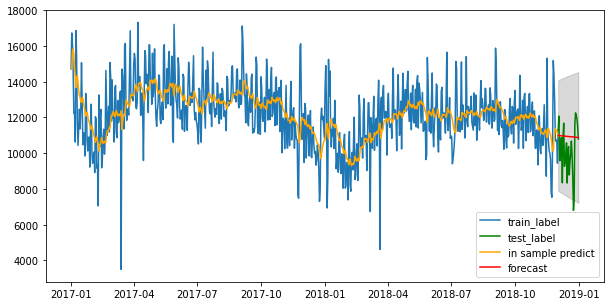

In [106]:
forecast = model_fit.forecast(steps=len(series)-N, alpha=0.05)[0]  # 95% conf
# Forecast
fc, se, conf = model_fit.forecast(steps=len(series)-N, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=range(N,len(series)))
lower_series = pd.Series(conf[:, 0], index=range(N,len(series)))
upper_series = pd.Series(conf[:, 1], index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(10,5)})
# plt.plot(series)

# plt.plot(series)
plt.plot(pd.to_datetime(JFKridershipDaily.index)[:N+1],series[:N+1],label='train_label')
plt.plot(pd.to_datetime(JFKridershipDaily.index)[N:],series[N:],color='green',label='test_label')
plt.plot(pd.to_datetime(JFKridershipDaily.index)[1:N+1],model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),color='orange',label='in sample predict')
plt.plot(pd.to_datetime(JFKridershipDaily.index)[N:],fc_series.tolist(), label='forecast', color='red')
plt.fill_between(pd.to_datetime(JFKridershipDaily.index)[N:], lower_series, upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='lower right')



# Taxi zone level prediction

This project aims to predict hourly yellow taxi ridership volume from JFK to each taxi zone. The ARIMA experiment in section 3 forecasts the total ridership amount from JFK. However, based on the reported $R^2$, this model is not a good fit. ARIMA model has four main shortcomings: 1) they rely heavily on stationarity assumption which does not hold in real-world traffic systems 2) they do not consider spatial and structural dependencies that traffic networks exhibit and forecast each sensor as an individual time series 3) they are unable to model non-linear temporal dynamics 4) they suffer from the curse of dimensionality. Due to the limitation of ARIMA, we need to apply another method to predict taxi zone level ridership.

## 5. Feature engineering

Our workflow is first standardizing the dataset, then using PCA to compress the dataset. As we predict future ridership, PCA should be learned from historical data (2017) then apply to the following year (2018). Next, add lag features (PCA components) from the past 12 hours and apply a Random Forest regressor to predict each PCA component's values in the next hour. After we had the PCA component prediction, inverse PCA, and inverse standardization to retrieve taxi ridership prediction in its original scale and dimension, in other words, we are predicting the PCA components instead of taxi zone level ridership and then using the inverse PCA method to reconstruct 

In [71]:
# standardization
def standardize(matrix):
    m = matrix.copy()
    scaler = StandardScaler()
    scaler.fit(m)
    t = scaler.transform(m)
    return scaler, t
# inverse stantdardization for prediction to compare with the raw dataset
def inverse_standardize(matrix, scaler):
    t = matrix.copy()
    return scaler.inverse_transform(t)

In [72]:
# dimension reduction
def getPCAFeatures(transformer, matrix):
    reducedMatrixPCA = transformer.transform(matrix)
    reducedDict = {str(i+1):reducedMatrixPCA[:,i] for i in range(reducedMatrixPCA.shape[1])}
    reducedDf = pd.DataFrame(reducedDict)
    return reducedDf
# reconverse the PCA component back to raw dataset's dimentsion
def inversePCA(matrix,pca):
    m = matrix.copy()
    return pca.inverse_transform(m)

### 5.1. standardization. (3 pts)
The standardscaler stores information of this standardization process, including the mean and standard deviation values required when converting the prediction back to the raw scale. Split the whole dataset into two parts: 2017 and 2018, standardize each separately.

In [78]:
JFKridership2017 = JFKridership.iloc[:365*24]
JFKridership2018 = JFKridership.iloc[365*24:]

In [79]:
JFKridership2017

,date,hour,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,256.0,257.0,258.0,259.0,260.0,261.0,262.0,263.0,264.0,265.0
0,2017-01-01,00,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,27.0
1,2017-01-01,01,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,...,6.0,0.0,0.0,0.0,0.0,5.0,7.0,6.0,1.0,12.0
2,2017-01-01,02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,2017-01-01,03,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,2017-01-01,04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,2017-12-31,19,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,...,6.0,2.0,0.0,0.0,1.0,5.0,3.0,2.0,0.0,17.0
8755,2017-12-31,20,0.0,0.0,4.0,2.0,0.0,0.0,14.0,0.0,...,5.0,4.0,3.0,0.0,9.0,1.0,5.0,20.0,0.0,8.0
8756,2017-12-31,21,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,...,3.0,2.0,3.0,0.0,0.0,4.0,17.0,7.0,1.0,35.0
8757,2017-12-31,22,1.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,...,2.0,0.0,0.0,0.0,0.0,2.0,11.0,13.0,1.0,12.0


In [80]:
standardscaler2017, matrix2017 = standardize(JFKridership2017.drop(columns=['date','hour']))
standardscaler2018, matrix2018 = standardize(JFKridership2018.drop(columns=['date','hour']))

### 5.2. PCA

#### 5.2.1 train PCA on 2017 data. Let's arbitrarily set PCA components as 5, and gamma is None, try kernel ‘linear’, ‘poly’, ‘rbf’, and ‘sigmoid’. Select the transformer which has the lowest mean squared error in data reconstruction (inverse transform). (5 pts)

In [81]:
pca_comps = 5

In [82]:
mse_result = {}
for kernel in ['linear','sigmoid','poly','rbf']:
    pca = KernelPCA(n_components=pca_comps,kernel=kernel,gamma=None,fit_inverse_transform=True)
    X_reduced = pca.fit_transform(matrix2017)
    X_reverse = pca.inverse_transform(X_reduced)
    mse = mean_squared_error(matrix2017, X_reverse)
    mse_result[kernel] = mse

In [83]:
sorted(mse_result.items(), key=lambda item: item[1], reverse=False)

[('linear', 0.8172867273782234),
 ('sigmoid', 0.8238738787530594),
 ('rbf', 0.835464172886209),
 ('poly', 0.8378384386480983)]

#### 5.2.2 Apply the selected transformer from 4.2.1 to the standardized 2018 dataset and report the mean squared error between the standardized data and reconstructed data. Hint: fit the PCA on 2017 data and apply it to transform 2018 data.(5pts)

In [84]:
pca = KernelPCA(n_components=pca_comps,kernel='linear',gamma=None,fit_inverse_transform=True)
reduced2018 = pca.fit_transform(matrix2018)
print(mean_squared_error(matrix2018,pca.inverse_transform(reduced2018)))

0.8248590348748092


### 5.3 Add lag (5pts)
add 12 lags of each component from 4.2.2 (compressed 2018 data only). The expected output should have 65 dimensions. In the further modeling step, we will apply the 60 lag variables to predict the 5 components.

In [85]:
# add 12 lag value for each PCA component
def addLag(dataset, maxlag, lagColumns):
    dataset_list = [dataset]

    for l in range(1, maxlag+1):
        df = dataset.shift(l)
        df = df[lagColumns]
        df.columns = [c+'_lag_'+str(l) for c in df.columns]
        dataset_list.append(df)

    dataset = pd.concat(dataset_list, axis=1).dropna()
    return dataset

In [86]:
reduced2018 = pd.DataFrame(reduced2018, columns=range(1,pca_comps+1))
reduced2018.columns = [str(i) for i in reduced2018.columns]

In [123]:
lagColumns = [str(i) for i in range(1,pca_comps+1)]
targetColumns = [str(i) for i in range(1,pca_comps+1)]
reduced2018_lag = addLag(reduced2018, 12, lagColumns)


In [124]:
reduced2018_lag

,1,2,3,4,5,1_lag_1,2_lag_1,3_lag_1,4_lag_1,5_lag_1,...,1_lag_11,2_lag_11,3_lag_11,4_lag_11,5_lag_11,1_lag_12,2_lag_12,3_lag_12,4_lag_12,5_lag_12
12,1.040523,0.363840,3.465837,-1.104718,1.931564,-2.664478,1.495311,-0.499059,-0.502654,-0.144161,...,-4.802427,3.689195,-1.423831,0.595256,-1.742917,-2.777510,4.482268,-0.766998,0.032220,1.976579
13,1.683809,-1.019307,1.948915,1.279656,1.428750,1.040523,0.363840,3.465837,-1.104718,1.931564,...,-8.778063,0.704671,0.769271,-0.386922,-0.083721,-4.802427,3.689195,-1.423831,0.595256,-1.742917
14,9.100059,0.791366,2.758701,-0.000728,3.544482,1.683809,-1.019307,1.948915,1.279656,1.428750,...,-8.611176,0.912489,0.697618,0.339413,1.203692,-8.778063,0.704671,0.769271,-0.386922,-0.083721
15,10.990321,-0.007905,6.035496,1.386558,1.699737,9.100059,0.791366,2.758701,-0.000728,3.544482,...,-7.915599,1.612142,-0.809723,-1.050294,-0.669355,-8.611176,0.912489,0.697618,0.339413,1.203692
16,8.322779,0.566146,4.583486,-0.645068,1.533844,10.990321,-0.007905,6.035496,1.386558,1.699737,...,-2.785730,2.859016,0.342471,1.308911,2.200759,-7.915599,1.612142,-0.809723,-1.050294,-0.669355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,7.372910,4.596384,1.091831,1.369456,2.035088,-1.329147,1.358542,1.688122,-1.316288,0.783688,...,1.229897,1.056167,0.010036,2.879663,0.964169,-0.778202,1.043450,2.438404,0.301327,1.097359
8755,5.986419,5.793787,3.798710,0.342779,1.974064,7.372910,4.596384,1.091831,1.369456,2.035088,...,-2.859364,0.661745,0.204809,0.229377,1.312831,1.229897,1.056167,0.010036,2.879663,0.964169
8756,8.531819,8.159513,4.069247,0.133768,1.419359,5.986419,5.793787,3.798710,0.342779,1.974064,...,-2.947173,1.902483,0.462128,0.103190,-1.065838,-2.859364,0.661745,0.204809,0.229377,1.312831
8757,7.970936,7.467378,1.358999,3.846159,-0.408936,8.531819,8.159513,4.069247,0.133768,1.419359,...,-3.468488,0.564814,0.202308,0.057022,-0.000998,-2.947173,1.902483,0.462128,0.103190,-1.065838


## 6. RandomForest modeling (23pts)

We aim at predicting compressed daily ridership (5 PCA components values) from 12-hour lag variables. Parameter tuning is required in this section, including min_samples_split, min_samples_leaf, and n_estimators. First 80% days for training, test on the rest 20%. And in the training dataset, validate the model on the bottom 20%. 


### Extra credit: 

Using grid_search function in sklearn instead of a for-loop when tuning parameters in a RandomForest. The train, validation, and test datasets should be split in the same way as described above. Hint: To fix train and validation in a grid search, you might need the PredefinedSplit function from sklearn.

### 6.1 train test split (3pts)
Please keep in mind that random train test split is not applicable in this case.

In [125]:
train_size = int(reduced2018_lag.shape[0]*0.8)
val_size = int(train_size*0.2)
train_data, test_data = reduced2018_lag[:train_size], reduced2018_lag[train_size:]

In [126]:
X_train,y_train = train_data.drop(columns=lagColumns), train_data[lagColumns]
X_test,y_test = test_data.drop(columns=lagColumns), test_data[lagColumns]

X_val,y_val = X_train[:val_size],y_train[:val_size]
X_train,y_train = X_train[val_size:],y_train[val_size:]

### 6.2 parameter tuning (10pts)
Please search the best parameter set in the following range:
min_samples_split: 2 to 10,
min_samples_leaf: 2 to 10,
and n_estimators equal to 50.


#### for-loop solution

In [127]:
validation_r2 = 0
parameter_set = []
n_estimators = 50
for min_samples_split in np.arange(2, 10, 5):
    for min_samples_leaf in np.arange(2, 10, 5):
        rf = RandomForestRegressor(n_estimators=n_estimators,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state = 2019) 
        rf.fit(X_train,y_train)
        r2 = r2_score(y_val,rf.predict(X_val))
        if r2 > validation_r2:
            validation_r2 = r2
            parameter_set = [n_estimators,min_samples_split,min_samples_leaf,max_depth]

In [129]:
best_rf = RandomForestRegressor(n_estimators=n_estimators,
                                   min_samples_split=parameter_set[1],
                                   min_samples_leaf=parameter_set[2],
                                   random_state = 2019) 

#### grid search solution

In [130]:
X_train,y_train = train_data.drop(columns=lagColumns), train_data[lagColumns]
X_test,y_test = test_data.drop(columns=lagColumns), test_data[lagColumns]

val_size = int(train_size*0.8)
val_fold = list(-1*np.ones(X_train.shape[0]-val_size)) + list(np.zeros(val_size))
ps = PredefinedSplit(val_fold)
param_grid = [{
    "n_estimators": [150],
    "min_samples_split": np.arange(2, 10, 5),
    'min_samples_leaf': np.arange(2, 10, 5), 
}]

rf = RandomForestRegressor(random_state = 2019) 
rf_grid_search = GridSearchCV(rf, param_grid, cv=ps, scoring='r2')
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=2019,
                                           

In [131]:
rf_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=2019, verbose=0, warm_start=False)

In [ ]:
best_rf = rf_grid_search.best_estimator_

### 6.3 model performance measurement (10pts)
Prediction results are PCA components instead of taxi zone level ridership. To reconstruct the data back to its original size and scale, we need to inverse PCA and inverse standardization. Report the taxi zone level $R^2$ value.

In [133]:
best_rf.fit(X_train,y_train)
print("Train R2: ",best_rf.score(X_train,y_train))
test_r2 = best_rf.score(X_test,y_test)
print("Test R2: ",test_r2)
# component prediction
pca_prediction = best_rf.predict(X_test)
# inverse PCA to get taxizone prediction
taxizone_prediction = inversePCA(pca_prediction,pca)
taxizone_prediction = inverse_standardize(taxizone_prediction, standardscaler2018)
# r2 score is an average of each taxi zone prediction's r2 score weighted by variance of each output
print("Taxi zone leve test R2: ", r2_score(JFKridership2018.drop(columns=['date','hour']).iloc[train_size+12:], taxizone_prediction, multioutput='variance_weighted'))

Train R2:  0.9385958850152278
Test R2:  0.7407588310368609
Taxi zone leve test R2:  0.418214915998188
